In [56]:
import pandas as pd
import altair as alt
from IPython.display import display, Markdown
import missingno as msno

In [95]:
df = pd.read_csv('/Users/kaitlinsinger/wa_notify/DEN_future/data_extraction/manipulated_data/simplified_wide_df_with_date_loc_imputed.csv')

In [96]:
df.head()

,Unnamed: 0,Unnamed: 0.1,source,pm_start_date,pm_end_date,pm_location,cases_assigned_count,cases_interviewed_count,cases_interviewed_from_positive_hdcount,cases_interviewed_from_positive_mean,...,staff_hired_ci_per_hd_mean,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_hd_mean,staff_hired_per_10kpop,test_result_from_collection_mean,user_cases_notifying,users_with_code,region,time_period
0,0,0,A Multifaceted Evaluation of a COVID-19 Contac...,2021-03-01,03/31/2021,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T3
1,1,1,A Multifaceted Evaluation of a COVID-19 Contac...,2021-04-01,06/30/2020,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T4
2,2,2,A Multifaceted Evaluation of a COVID-19 Contac...,2020-07-01,06/30/2021,King County,52317.0,42900.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T2
3,3,3,A Multifaceted Evaluation of a COVID-19 Contac...,2020-07-01,09/30/2020,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T2
4,4,4,A Patient-Initiated Digital COVID-19 Contact N...,2020-05-18,08/17/2020,United States*,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,T2


In [110]:
#df.columns

In [112]:
cols_interest = ['source', 'pm_start_date', 'pm_end_date',
       'pm_location', 'cases_assigned_count', 'cases_interviewed_count',
        'cases_interviewed_perc',
       'cases_named_contacts_count',
       'cases_not_assigned_count',
       'cases_per_staff_month', 
       'cases_positive_from_test_mean', 'cases_positive_from_test_med',
       'cases_reached_count', 'cases_reached_from_symptom_mean',
       'cases_reached_from_symptom_med', 'cases_reached_from_test_max',
       'cases_reached_from_test_mean', 'cases_reached_from_test_med',
       'cases_reached_perc', 
        # 'contact_named_count', 'contacts_per_staff_month', # needs fixing
        'contacts_assigned_count',
       'contacts_infected_count', 'contacts_infected_perc',
       'contacts_interviewed_count', 'contacts_interviewed_perc',
       'contacts_named_cases_naming', 'contacts_named_cases_naming_ratio',
       'contacts_named_cases_naming_ratio_mean', 'contacts_named_count',
       'contacts_named_count_household', 
        'contacts_named_perc',
       'contacts_named_perc_household', 'contacts_named_ratio_mean',
       'contacts_named_ratio_mean_cases_naming',
       'contacts_named_ratio_mean_household', 'contacts_named_ratio_med',
       'contacts_reached_count', 'contacts_reached_from_cases_pos_mean',
       'contacts_reached_from_cases_pos_med',
       'contacts_reached_from_cases_test_mean',
       'contacts_reached_from_exposure_mean',
       'contacts_reached_from_named_hdcount',
       'contacts_reached_from_named_mean', 'contacts_reached_from_named_med',
       'contacts_reached_perc',
        'hr_cost', 'hr_hours', 'monetary_cost',
       'notifications_recieved_count', 'notifications_sent_max',
       'num_users_count', 'num_users_upper_bound', 'percent_naming_contacts',
       'quarantine_adherent_perc', 'staff_hired_ci_count',
       'staff_hired_ci_per_hd_mean', 'staff_hired_count',
       'staff_hired_ct_count', 'staff_hired_ct_per_hd_mean',
       'staff_hired_per_10kpop', 'test_result_from_collection_mean',
       'user_cases_notifying', 'users_with_code', 'region', 'time_period']

In [113]:
# fuzzy columns


In [114]:
df['ratio_cases_contacts_intv'] = df['cases_interviewed_count']/df['contacts_interviewed_count']

In [115]:
# data profiling
df.describe()

,Unnamed: 0,Unnamed: 0.1,cases_assigned_count,cases_interviewed_count,cases_interviewed_from_positive_hdcount,cases_interviewed_from_positive_mean,cases_interviewed_from_positive_med,cases_interviewed_perc,cases_interviewed_perc_hdcount,cases_interviewed_perc_mean,...,staff_hired_ci_count,staff_hired_ci_per_hd_mean,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_hd_mean,staff_hired_per_10kpop,test_result_from_collection_mean,user_cases_notifying,users_with_code,ratio_cases_contacts_intv
count,83.000000,83.000000,5.700000e+01,4.500000e+01,14.000000,14.000000,14.000000,50.000000,14.000000,14.000000,...,14.000000,14.000000,1.0,14.00000,14.000000,1.00,1.00,2.000000,2.000000,7.000000
mean,41.000000,41.000000,8.424556e+05,4.451350e+05,50.357143,38.914286,25.714286,65.375600,52.285714,53.321429,...,37499.500000,714.428571,962.0,35464.00000,664.285714,4.15,13.68,72521.500000,261789.500000,2.405160
std,24.103942,24.103942,1.640655e+06,7.101208e+05,1.984833,12.025029,6.414270,20.814334,1.857565,8.460331,...,10845.303441,202.581689,NaN,12265.24458,229.232978,NaN,NaN,6243.045771,261422.326752,2.423153
min,0.000000,0.000000,4.000000e+01,4.000000e+01,47.000000,26.400000,24.000000,26.610000,47.000000,32.400000,...,26288.000000,487.000000,962.0,22292.00000,425.000000,4.15,13.68,68107.000000,76936.000000,0.561793
25%,20.500000,20.500000,4.987000e+03,3.534000e+03,50.000000,29.400000,24.000000,48.262500,52.250000,50.350000,...,28847.750000,562.000000,962.0,24107.00000,458.000000,4.15,13.68,70314.250000,169362.750000,1.085871
50%,41.000000,41.000000,1.410600e+04,1.029000e+04,51.000000,37.200000,24.000000,68.755000,53.000000,53.500000,...,32354.500000,628.000000,962.0,31645.00000,586.000000,4.15,13.68,72521.500000,261789.500000,1.204984
75%,61.500000,61.500000,9.410350e+05,7.113790e+05,51.750000,44.400000,24.000000,81.000000,53.000000,60.650000,...,45323.250000,855.000000,962.0,45371.25000,852.000000,4.15,13.68,74728.750000,354216.250000,2.748686
max,82.000000,82.000000,6.078802e+06,2.681000e+06,53.000000,64.800000,48.000000,100.000000,54.000000,61.800000,...,54651.000000,1072.000000,962.0,54905.00000,1077.000000,4.15,13.68,76936.000000,446643.000000,7.400227


<AxesSubplot:>

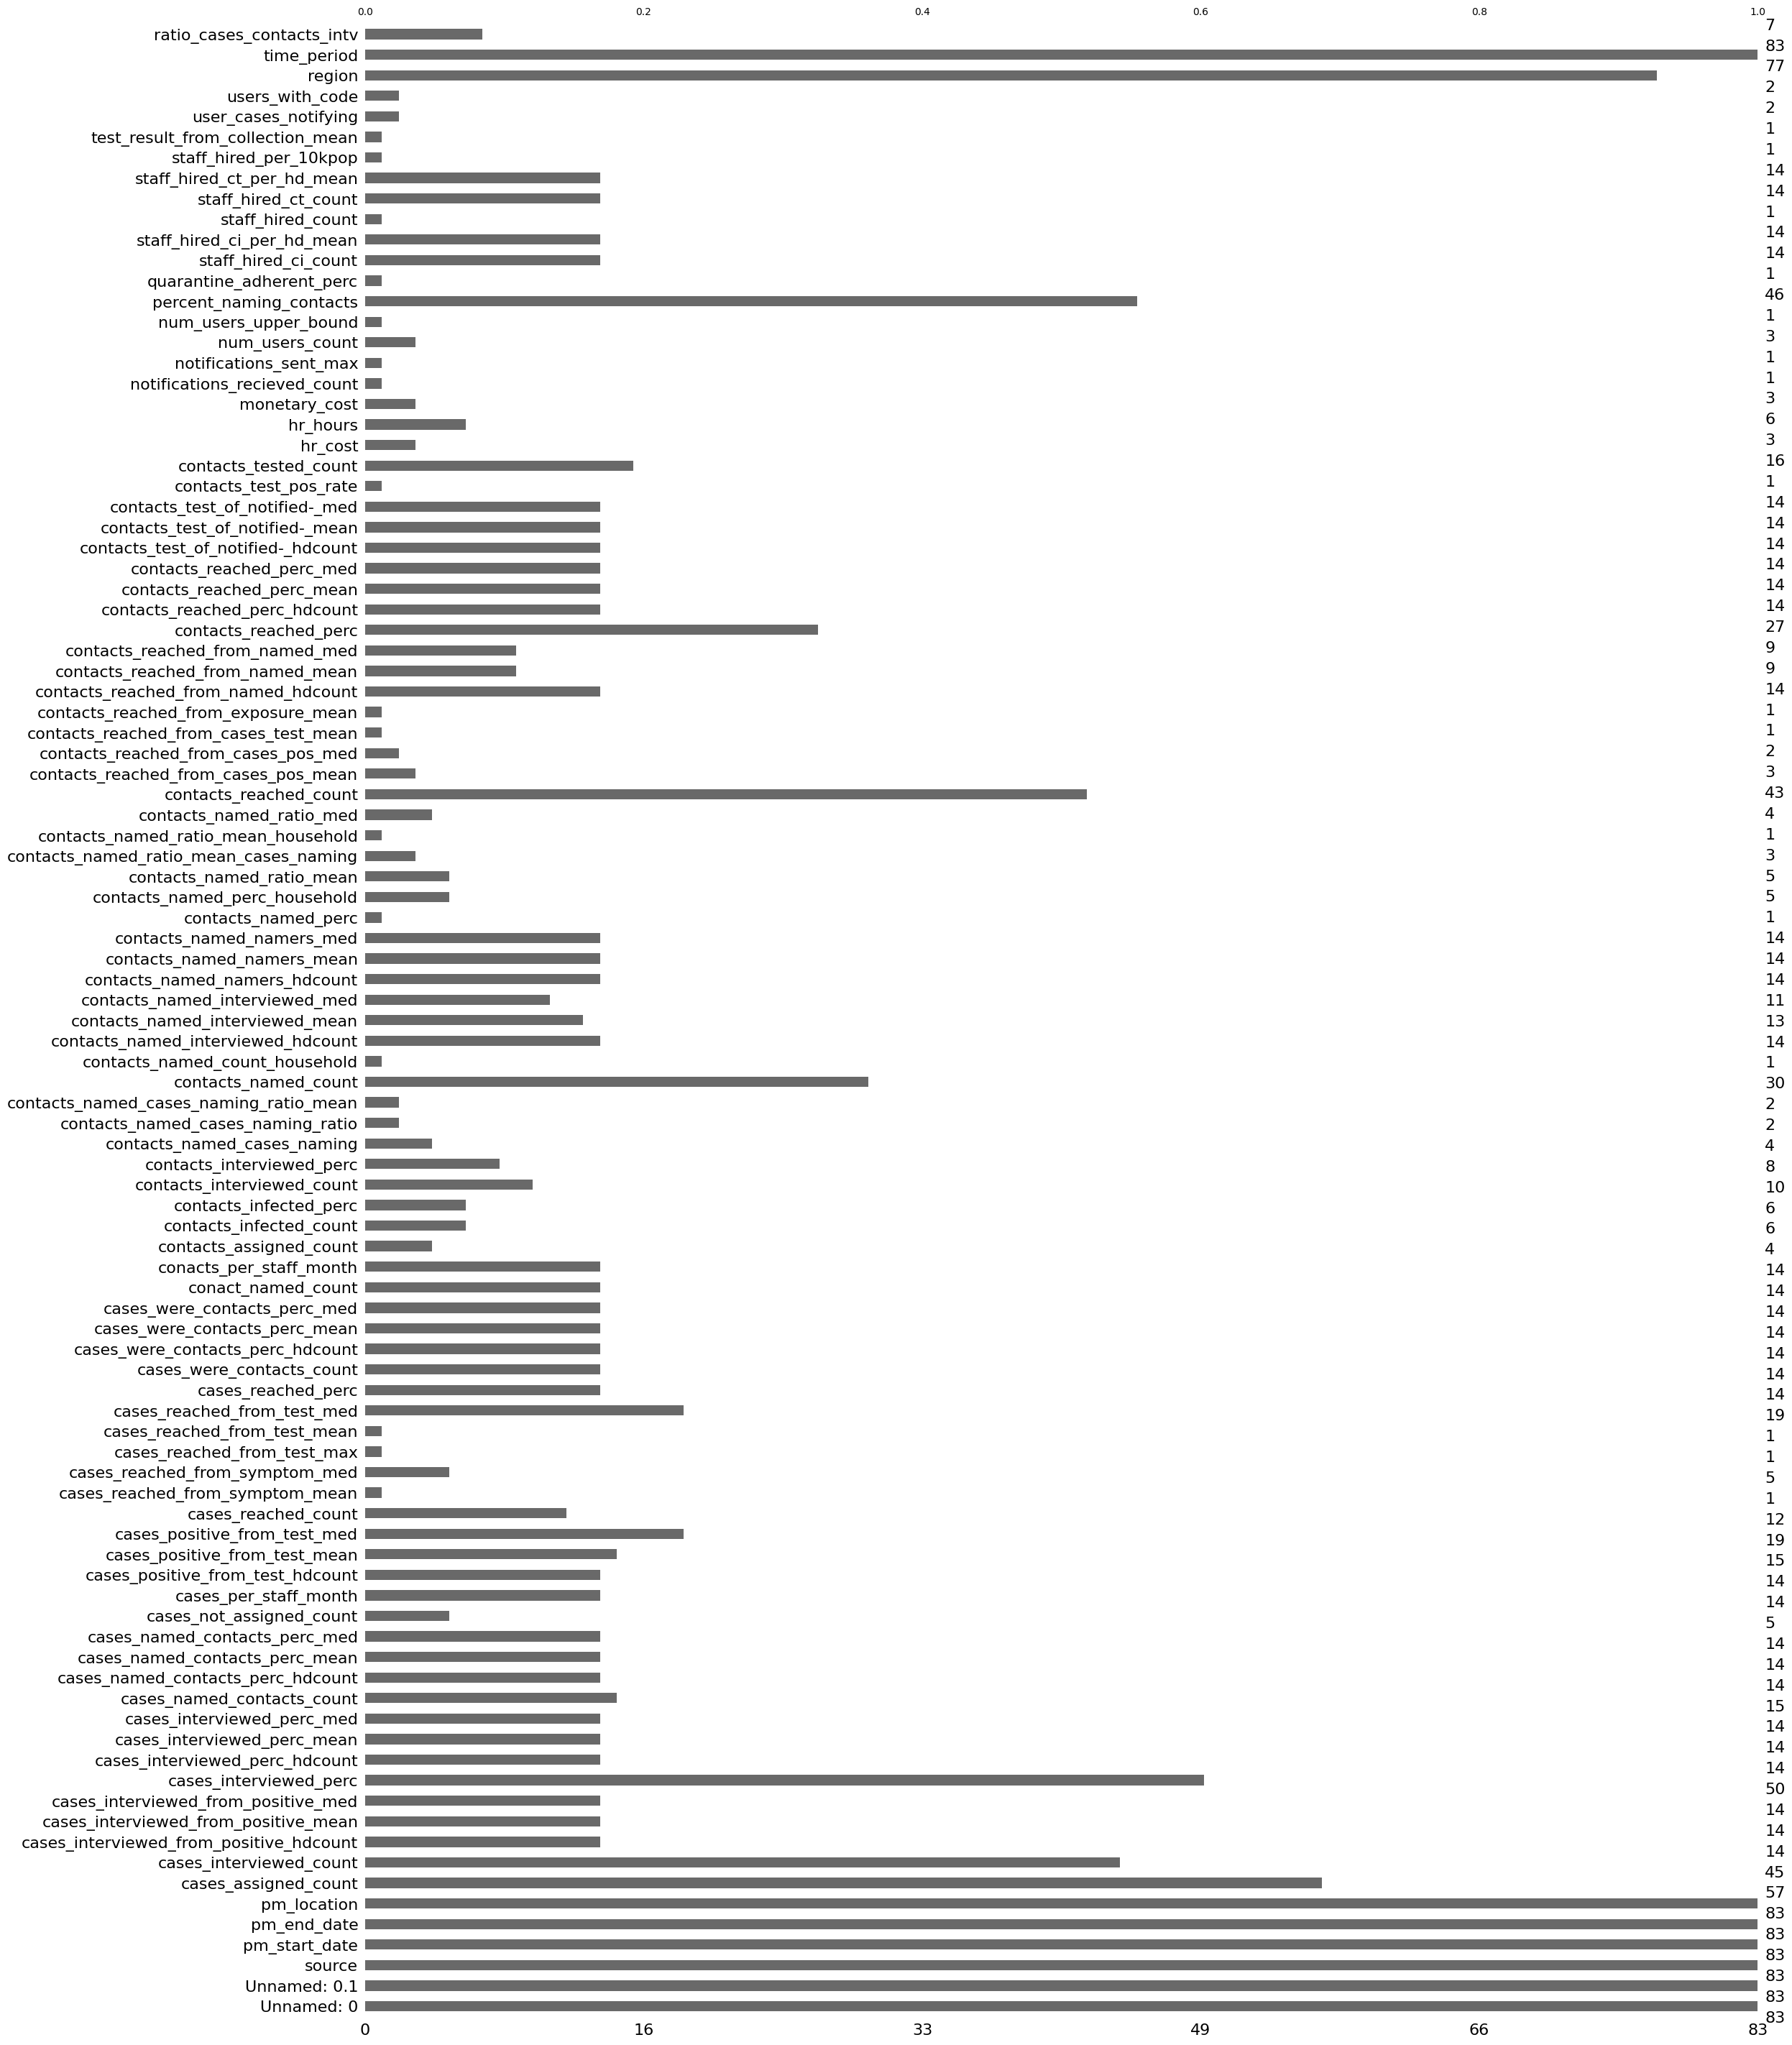

In [120]:
# missingness map
#msno.matrix(df[cols_interest], labels=True, label_rotation=90)
#plt.show()
msno.bar(df)

In [67]:
# data analysis

In [66]:
alt.Chart(df).mark_tick().encode(
    alt.X('cases_assigned_count:Q')
)

alt.Chart(...)

In [122]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_assigned_count:Q",  scale=alt.Scale(type='log')),
    alt.Y("source:N")
)

alt.Chart(...)

In [123]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_interviewed_count:Q",  scale=alt.Scale(type='log')),
    alt.Y("source:N")
)

alt.Chart(...)

In [63]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_interviewed_perc:Q"),
    alt.Y("source:N")
)

alt.Chart(...)

In [82]:
alt.Chart(df).mark_point().encode(
    alt.X("ratio_cases_contacts_intv:Q"),
    alt.Y("source:N")
)

alt.Chart(...)

In [64]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_interviewed_perc:Q"),
    alt.Y("region:N")
)

alt.Chart(...)

In [80]:
alt.Chart(df).mark_point().encode(
    alt.X("time_period:O"),
    alt.Y("cases_interviewed_perc:Q"),
    alt.Size("cases_assigned_count:Q", ),
    #alt.Color("region:N"),
    tooltip = [
        alt.Tooltip("source:N"),
        alt.Tooltip("pm_start_date:T"),
        alt.Tooltip("pm_end_date:T")
   ]
).properties(
    width=500
)

alt.Chart(...)